In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/signs-detection-dataset/Signs_Data_Training.h5
/kaggle/input/signs-detection-dataset/Signs_Data_Testing.h5


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform, GlorotUniform
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
from sklearn.metrics import classification_report



In [3]:
!pip install h5py
import h5py

# Data Preprocessing:

Dimensioning and normalization of image data.

Conversion of labels to One-Hot Encoding format.

* Model Architecture:

3 convolutional layers, each followed by MaxPooling.

BatchNormalization increases the stability of the model.

Dropout layers prevent overfitting.

Last layer performs classification for 6 classes with Softmax.

* Data Augmentation:

Increasing the generalization ability of the model by varying the images with rotation, shift, reflection, etc.

* Early Stopping:

Over-learning of the model is prevented by monitoring the development of validation loss.

* Learning Rate Scheduler:

If the validation loss remains constant, the learning rate is reduced, which helps the model learn more stably.

* Model Evaluation:

The performance of the model is measured using the test set (accuracy and loss).

Detailed performance report is obtained with classification_report.

* Visualization of Images:

10 randomly selected images from both training and test sets are visualized.
Actual labels and predicted labels are shown.

In [4]:
train_data = h5py.File('/kaggle/input/signs-detection-dataset/Signs_Data_Training.h5')
test_data = h5py.File('/kaggle/input/signs-detection-dataset/Signs_Data_Testing.h5')

* What keys are there?

In [5]:
train_data.keys(), test_data.keys()

(<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>,
 <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>)

* This code extracts data from train_data and test_data files and assigns them to variables such as X_train, Y_train, X_test and Y_test.

In [6]:
 x_train = train_data['train_set_x']
y_train = train_data['train_set_y']
x_test = test_data['test_set_x']
y_test = test_data['test_set_y']

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((1080, 64, 64, 3), (1080,), (120, 64, 64, 3), (120,))

In [8]:
x_train

<HDF5 dataset "train_set_x": shape (1080, 64, 64, 3), type "|u1">

* Let's convert it into a Numpy Array

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
y_train = np.array(y_train)

* Image Scaling

Image data usually has pixel values ​​between 0 and 255. However, normalizing these values ​​between 0 and 1 allows the model to learn faster and more efficiently. Also, labels need to be in one-hot encoding format (if they are not already).

In [10]:
x_train = x_train / 255.0  
x_test = x_test / 255.0

In [11]:

if len(x_train.shape) == 3:
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)

In [12]:
print("Train Shape:", x_train.shape)
print("Test Shape:", x_test.shape)

Train Shape: (1080, 64, 64, 3)
Test Shape: (120, 64, 64, 3)


In [13]:

y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)


In [14]:
model = Sequential([
    Conv2D(32, (3, 3), strides=(1,1) , activation='relu', padding="same", kernel_initializer=HeUniform(), input_shape=(64,64,3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3),strides=(1,1), activation='relu', padding="same", kernel_initializer=HeUniform()),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding="same", kernel_initializer=HeUniform()),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    
    Flatten(),

    Dense(256, activation='relu', kernel_initializer=HeUniform()),
     BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_initializer=HeUniform()),
     BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu', kernel_initializer=HeUniform()),
     BatchNormalization(),
    
    Dense(6, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
from tensorflow.keras import losses

model.compile(optimizer=Adam(learning_rate=0.0001), loss=losses.CategoricalCrossentropy(), metrics=["accuracy"])


In [16]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2, 
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=14, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=20, validation_data=(x_test, y_test), callbacks=[early_stopping, reduce_lr])



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 561ms/step - accuracy: 0.1827 - loss: 2.2868 - val_accuracy: 0.2000 - val_loss: 1.9096 - learning_rate: 1.0000e-04
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 557ms/step - accuracy: 0.1996 - loss: 2.1736 - val_accuracy: 0.2667 - val_loss: 1.8072 - learning_rate: 1.0000e-04
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.2591 - loss: 2.0142 - val_accuracy: 0.1583 - val_loss: 1.7621 - learning_rate: 1.0000e-04
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 513ms/step - accuracy: 0.2729 - loss: 1.9091 - val_accuracy: 0.2167 - val_loss: 1.7259 - learning_rate: 1.0000e-04
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 530ms/step - accuracy: 0.2876 - loss: 1.8520 - val_accuracy: 0.1917 - val_loss: 1.7366 - learning_rate: 1.0000e-04
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.3243 - loss: 1.7805 - val_accuracy: 0.2000 - val_loss: 1.7359 - learning_rate: 1.0000e-04
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 510ms/step - accuracy: 0.3183 -

In [18]:


test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2535 - loss: 1.6552
Test Loss: 1.704100251197815
Test Accuracy: 0.22499999403953552


In [19]:
from sklearn.metrics import classification_report


y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_test, axis=1)  


report = classification_report(y_true, y_pred_classes)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.22      1.00      0.35        20
           2       0.00      0.00      0.00        20
           3       1.00      0.05      0.10        20
           4       0.33      0.20      0.25        20
           5       0.15      0.10      0.12        20

    accuracy                           0.23       120
   macro avg       0.28      0.23      0.14       120
weighted avg       0.28      0.23      0.14       120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



You can play with the values ​​to increase the accuracy of the model.

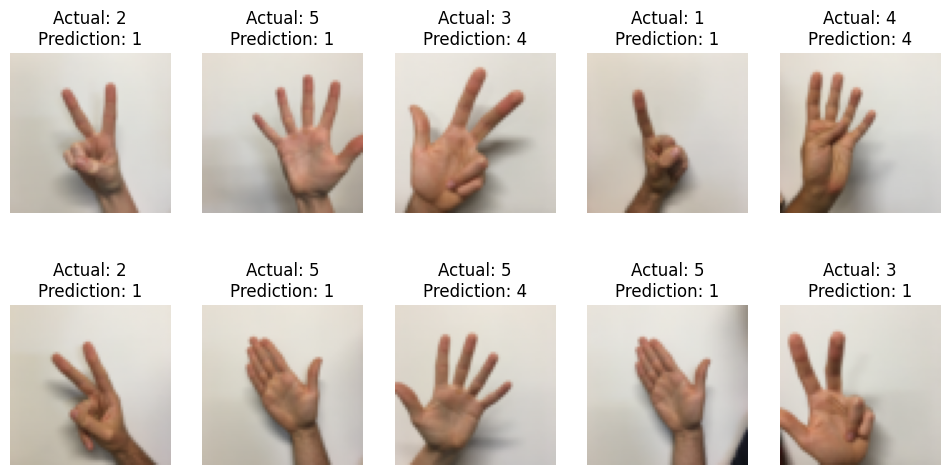

In [20]:
import matplotlib.pyplot as plt

# Select 10 random test images
indices = np.random.choice(len(x_test), 10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, idx in enumerate(indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(x_test[idx].squeeze(), cmap="gray") # If grayscale cmap="gray"
    ax.set_title(f"Actual: {np.argmax(y_test[idx])}\nPrediction: {y_pred_classes[idx]}")
    ax.axis("off")

plt.show()